In [16]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set_style('white')

import datetime as dt

In [2]:
hdb_2000_2012 = pd.read_csv('./dataset/resale-flat-prices/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
hdb_2012_2014 = pd.read_csv('./dataset/resale-flat-prices/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
hdb_2015_2016 = pd.read_csv('./dataset/resale-flat-prices/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
hdb_2017_2020 = pd.read_csv('./dataset/resale-flat-prices/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [3]:
print(hdb_2000_2012.shape)
print(hdb_2012_2014.shape)
print(hdb_2015_2016.shape)
print(hdb_2017_2020.shape)

(369651, 10)
(52203, 10)
(37153, 11)
(66497, 11)


In [48]:
hdb = pd.concat([hdb_2000_2012, hdb_2012_2014, hdb_2015_2016, hdb_2017_2020], axis=0, join='outer', sort=False)

# transform date columns
hdb['month'] = pd.to_datetime(hdb['month'])
hdb['lease_commence_date'] = pd.to_datetime(hdb['lease_commence_date'], format='%Y')

# creating more date columns
hdb['year_sold'] = hdb['month'].dt.year

# impute remaining lease
hdb['remaining_lease_in_years'] = 99 - (hdb['month'].dt.year - hdb['lease_commence_date'].dt.year)

# get remaining lease buckets
hdb['remaining_lease_in_5Y_buckets'] = hdb['remaining_lease_in_years'].apply(lambda x: x//5*5)

# lease commence year
hdb['lease_commence_year'] = hdb['lease_commence_date'].dt.year

# square feet
hdb['floor_area_sqft'] = hdb['floor_area_sqm'] * 10.7639

# price per square feet
hdb['price_per_sqft'] = hdb['resale_price'] / hdb['floor_area_sqft']

hdb = hdb[['month', 'year_sold', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 
           'floor_area_sqft', 'price_per_sqft', 'flat_model', 'lease_commence_date', 
           'remaining_lease_in_years', 'remaining_lease_in_5Y_buckets', 'resale_price']]

# export dataset
hdb.to_csv('./dataset/hdb_2000_2020.csv')

In [49]:
hdb.head(2)

,month,year_sold,town,flat_type,block,street_name,storey_range,floor_area_sqm,floor_area_sqft,price_per_sqft,flat_model,lease_commence_date,remaining_lease_in_years,remaining_lease_in_5Y_buckets,resale_price
0,2000-01-01,2000,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,742.7091,197.924059,Improved,1986-01-01,85,85,147000.0
1,2000-01-01,2000,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,656.5979,219.312307,Improved,1986-01-01,85,85,144000.0


In [50]:
flats_sold_per_town = hdb['town'].value_counts().reset_index().rename(columns={'index': 'town', 
                                                                               'town': 'num_flats'})

px.bar(flats_sold_per_town, x='town', y='num_flats', width=1000, height=450)

In [51]:
TOWN_TIER_1_PRX = ['Ang Mo Kio', 'Bishan', 'Geylang', 'Kallang/Whampoa', 'Serangoon', 'Toa Payoh']
TOWN_TIER_1_NOPRX = ['Bukit Merah', 'Queenstown', 'Central Area']

TOWN_TIER_2 = ['Bedok', 'Clementi', 'Hougang', 'Punggol', 'Sengkang']

TOWN_TIER_3 = ['Bukit Panjang', 'Bukit Batok', 'Bukit Timah', 'Choa Chu Kang', 'Jurong East', 'Jurong West', 
               'Marine Parade', 'Pasir Ris', 'Sembawang', 'Tampines', 'Woodlands', 'Yishun']

# changing all to upper case
TOWN_TIER_1_PRX = [town.upper() for town in TOWN_TIER_1_PRX]
TOWN_TIER_1_NOPRX = [town.upper() for town in TOWN_TIER_1_NOPRX]
TOWN_TIER_2 = [town.upper() for town in TOWN_TIER_2]
TOWN_TIER_3 = [town.upper() for town in TOWN_TIER_3]

In [52]:
flats_sold_per_flat_type = hdb['flat_type'].value_counts().reset_index().rename(columns={'index': 'flat_type', 
                                                                                         'flat_type': 'num_flats'})

px.bar(flats_sold_per_flat_type, x='flat_type', y='num_flats', width=600, height=400)

In [62]:
# instantiating masks

four_room_and_above = hdb['flat_type'].isin(['4 ROOM', '5 ROOM', 'EXECUTIVE'])
years_2010_2019 = (hdb['year_sold']>=2010) & (hdb['year_sold']<=2019)
years_2000_2019 = (hdb['year_sold']>=2000) & (hdb['year_sold']<=2019)
loc_tier1 = hdb['town'].isin(TOWN_TIER_1_PRX + TOWN_TIER_1_NOPRX)

In [63]:
hdb_4room_plus = hdb[four_room_and_above].sort_values(by='resale_price', ascending=False)
hdb_4room_plus.shape

(363301, 15)

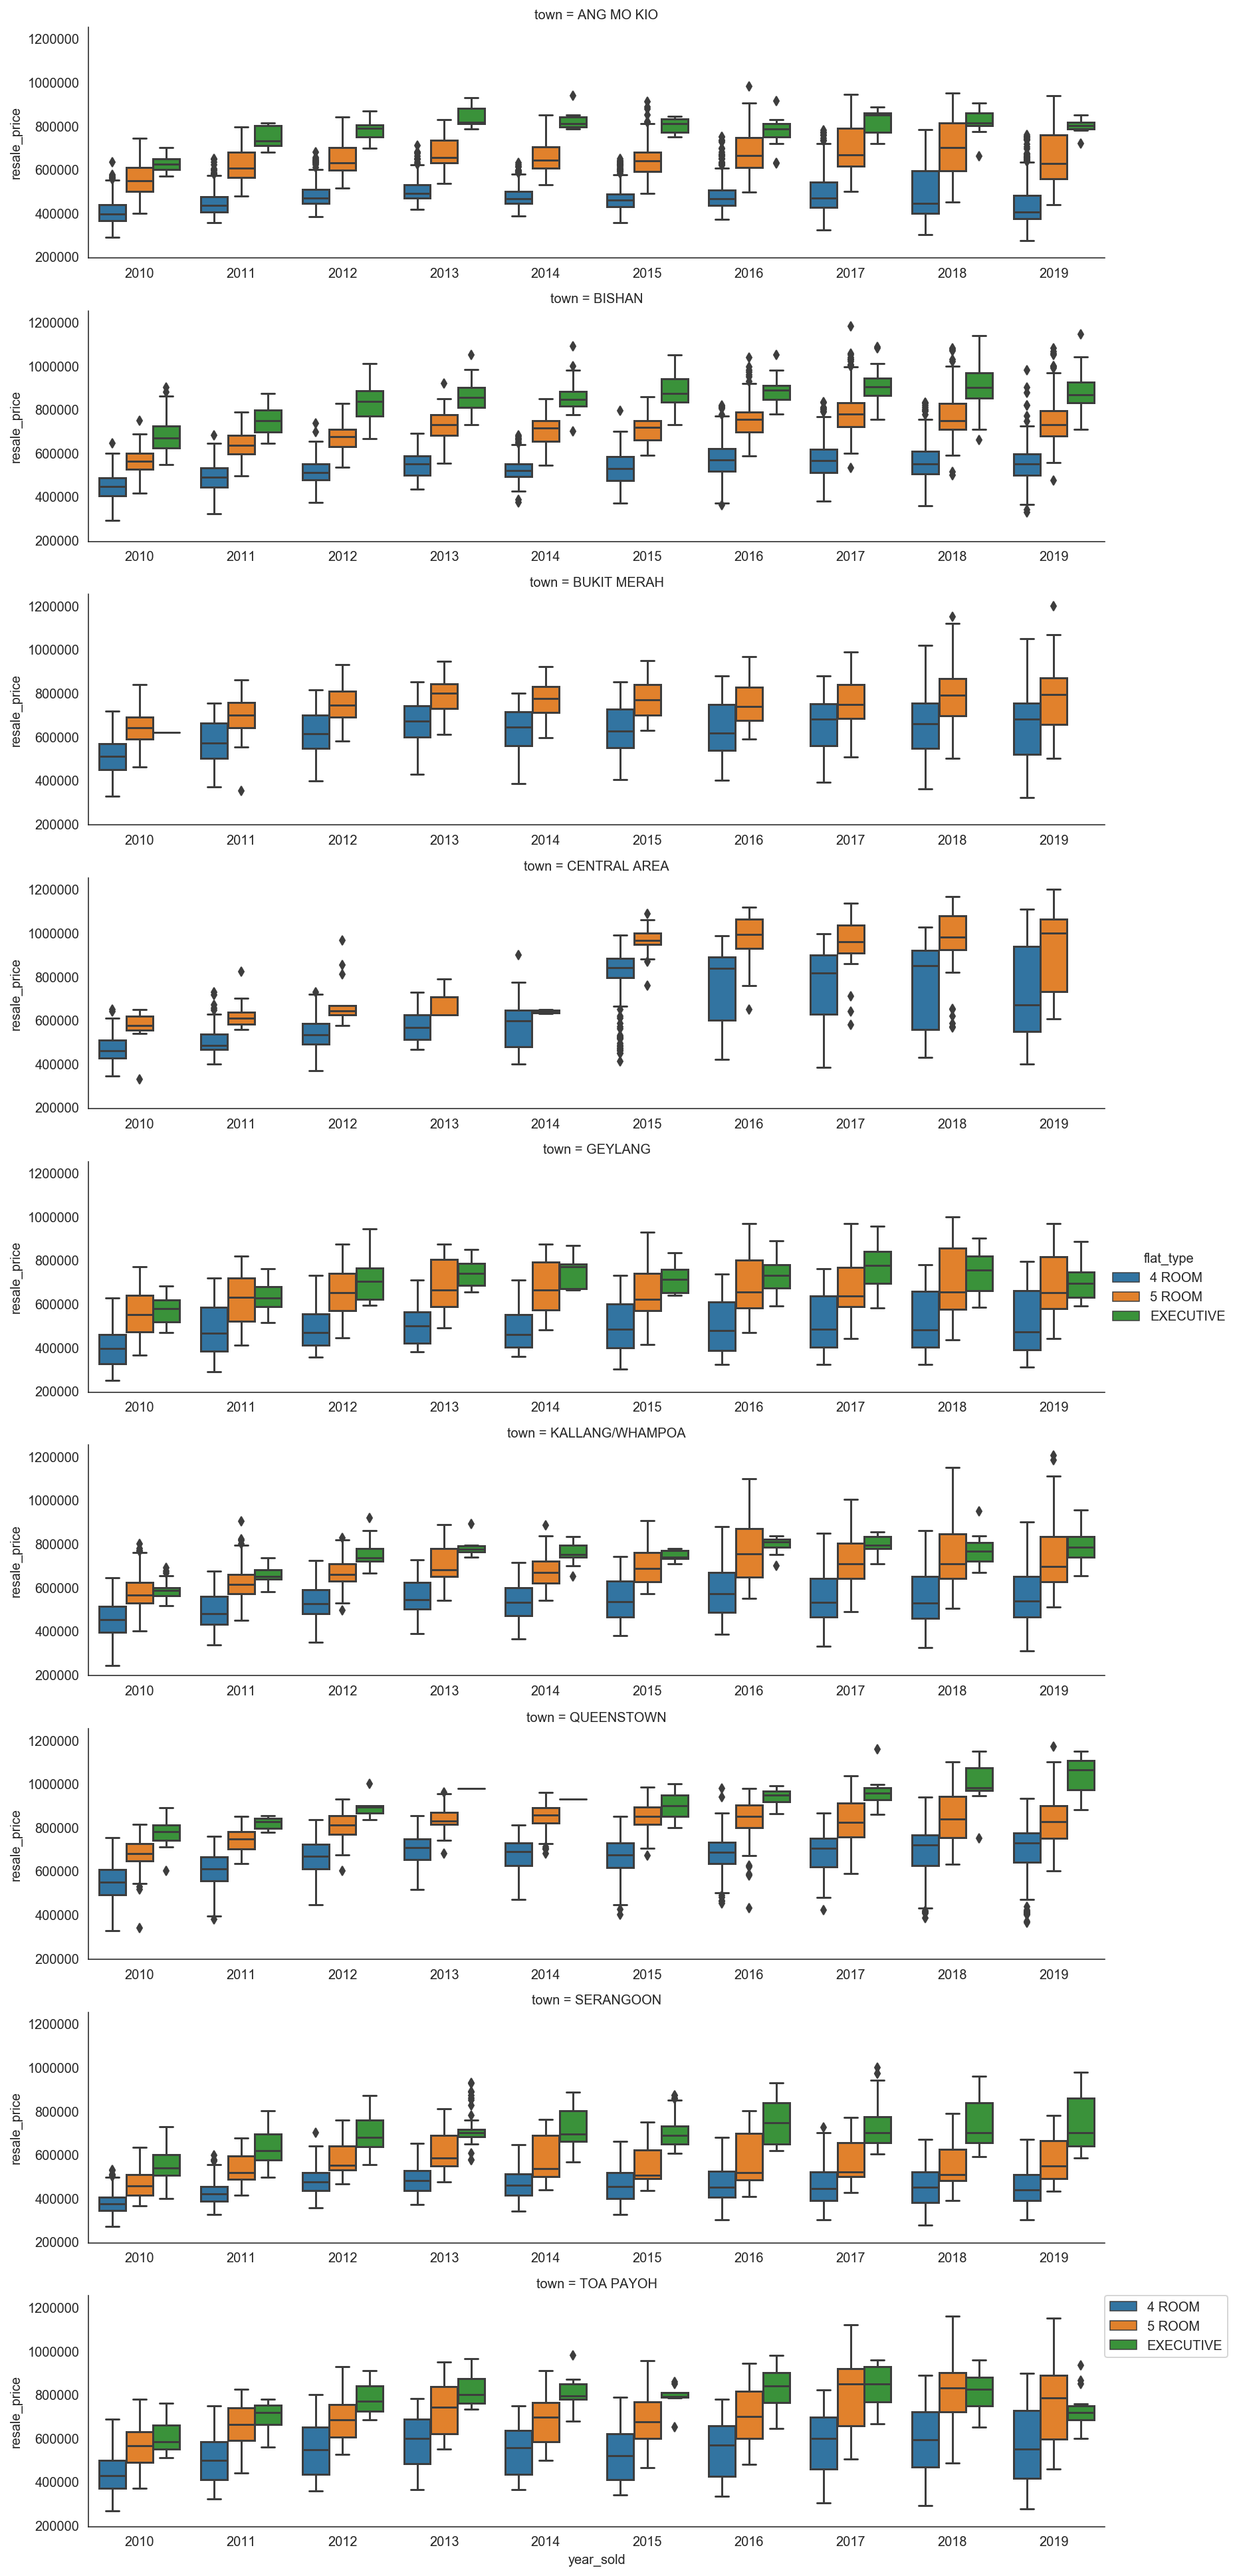

In [91]:
g = sns.catplot(x='year_sold', y='resale_price', kind='box', hue='flat_type', col='town', col_wrap=1, 
            data=hdb[four_room_and_above & years_2010_2019 & loc_tier1], 
            aspect=3.5, height=3, legend_out=True);

for ax in g.axes.flat:
    _ = plt.setp(ax.get_xticklabels(), visible=True)

g.fig.tight_layout()
plt.legend(bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.);

In [105]:
px.line(yearly_resale_prices_4roomsplus.stack().reset_index(), 
        x='year_sold', y='resale_price', color='level_1')

In [106]:
yearly_resale_prices_4roomsplus = hdb_4room_plus.groupby('year_sold').agg({'resale_price': [np.mean, np.median],
                                                                           'price_per_sqft': [np.mean, np.median]})
yearly_resale_prices_4roomsplus.stack().reset_index().rename(columns={'level_1':'central_tendency'})

,year_sold,central_tendency,resale_price,price_per_sqft
0,2000,mean,316900.377004,259.638993
1,2000,median,293000.000000,254.473791
2,2001,mean,289552.421174,238.060062
3,2001,median,268000.000000,232.257825
4,2002,mean,276123.795798,227.658617
5,2002,median,255000.000000,221.318286
6,2003,mean,271678.224465,228.342841
7,2003,median,253000.000000,223.655683
8,2004,mean,272012.930974,231.816087
9,2004,median,258000.000000,227.612668


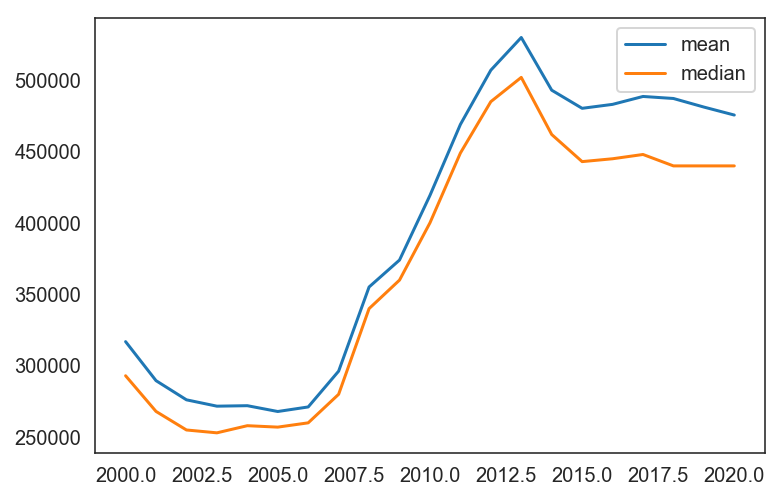

In [93]:
fig, ax = plt.subplots()

x = yearly_resale_prices_4roomsplus.index.to_list()
y = yearly_resale_prices_4roomsplus['resale_price']['mean']
y2 = yearly_resale_prices_4roomsplus['resale_price']['median']

ax.plot(x, y)
ax.plot(x, y2)
plt.legend();

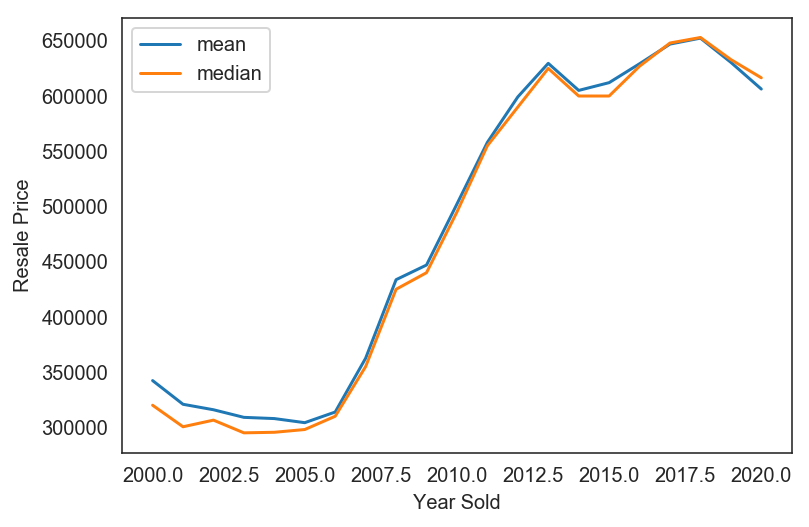

In [53]:
hdb_4roomplus_tier1 = hdb_4room_plus[hdb_4room_plus['town'].isin(TOWN_TIER_1_PRX + TOWN_TIER_1_NOPRX)]

yearly_resale_prices_4roomsplus_tier1 = hdb_4roomplus_tier1.groupby('year').agg({'resale_price': [np.mean, 
                                                                                                  np.median],
                                                                                 'price_per_sqft': [np.mean, 
                                                                                                    np.median]})

fig, ax = plt.subplots()

x = yearly_resale_prices_4roomsplus_tier1.index.to_list()
y = yearly_resale_prices_4roomsplus_tier1['resale_price']['mean']
y2 = yearly_resale_prices_4roomsplus_tier1['resale_price']['median']

ax.plot(x, y)
ax.plot(x, y2)
ax.set_xlabel('Year Sold')
ax.set_ylabel('Resale Price')
plt.legend();

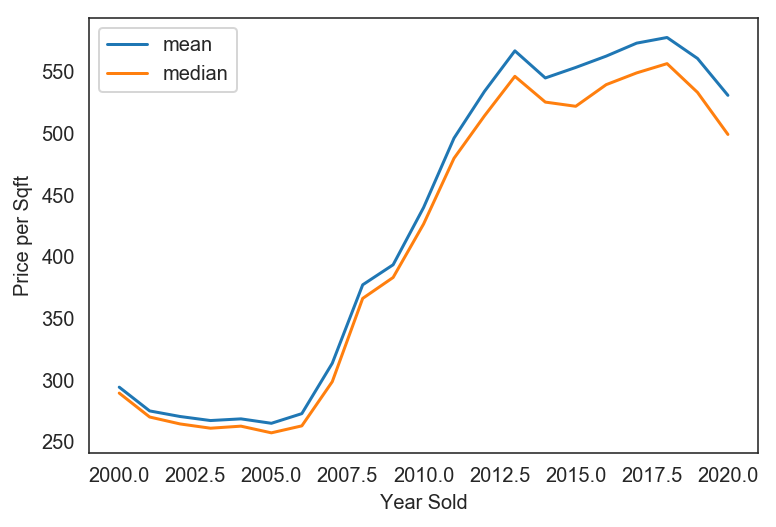

In [54]:
fig, ax = plt.subplots()

x = yearly_resale_prices_4roomsplus_tier1.index.to_list()
y = yearly_resale_prices_4roomsplus_tier1['price_per_sqft']['mean']
y2 = yearly_resale_prices_4roomsplus_tier1['price_per_sqft']['median']

ax.plot(x, y)
ax.plot(x, y2)
ax.set_xlabel('Year Sold')
ax.set_ylabel('Price per Sqft')
plt.legend();

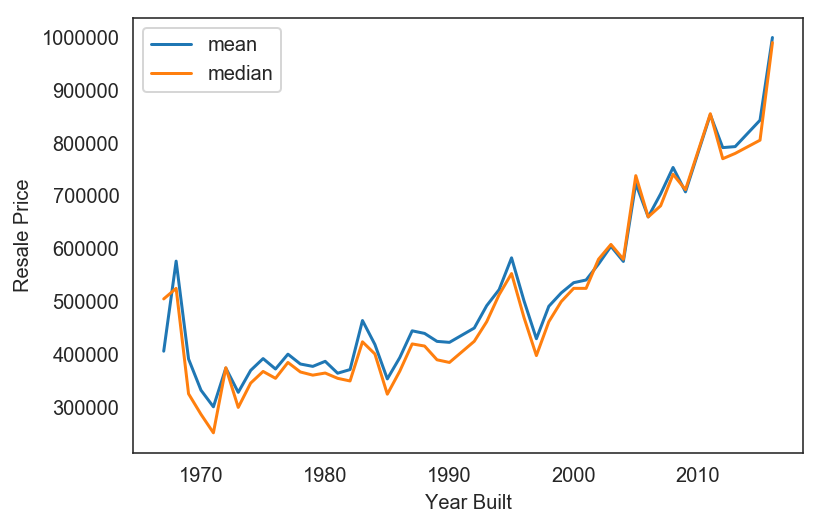

In [55]:
resale_prices_4roomsplus_tier1_by_year_built = (
    hdb_4roomplus_tier1
    .groupby('lease_commence_year')
    .agg(
        {
            'resale_price': [np.mean, np.median],
            'price_per_sqft': [np.mean, np.median]
        }
        )
)

fig, ax = plt.subplots()

x = resale_prices_4roomsplus_tier1_by_year_built.index.to_list()
y = resale_prices_4roomsplus_tier1_by_year_built['resale_price']['mean']
y2 = resale_prices_4roomsplus_tier1_by_year_built['resale_price']['median']

ax.plot(x, y)
ax.plot(x, y2)
ax.set_xlabel('Year Built')
ax.set_ylabel('Resale Price')
plt.legend();

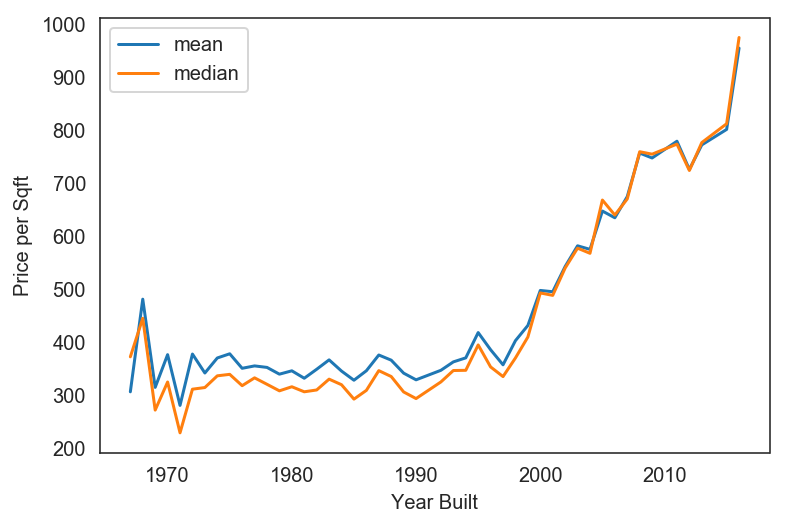

In [60]:
fig, ax = plt.subplots()

x = resale_prices_4roomsplus_tier1_by_year_built.index.to_list()
y = resale_prices_4roomsplus_tier1_by_year_built['price_per_sqft']['mean']
y2 = resale_prices_4roomsplus_tier1_by_year_built['price_per_sqft']['median']

ax.plot(x, y)
ax.plot(x, y2)
ax.set_xlabel('Year Built')
ax.set_ylabel('Price per Sqft')
plt.legend();

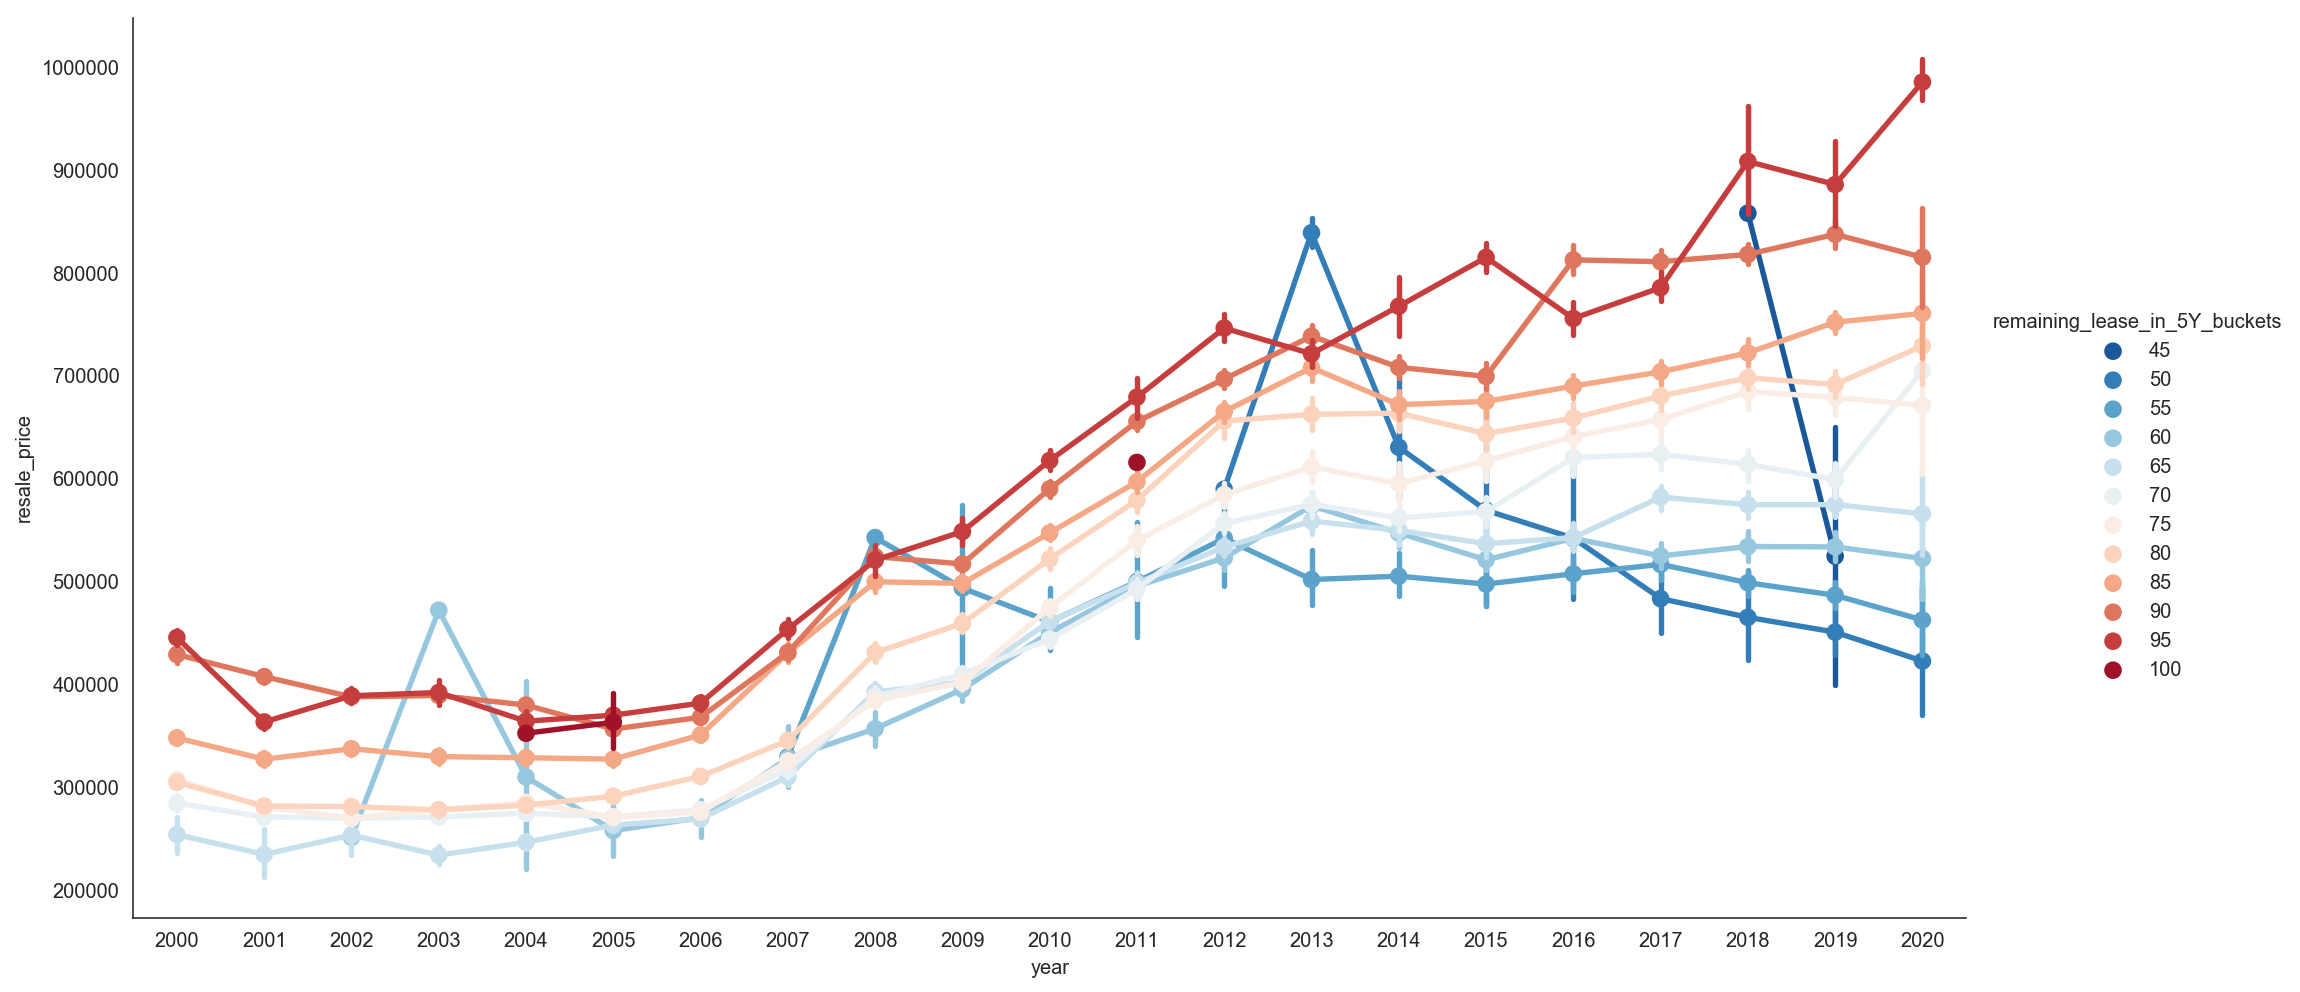

In [90]:
# plot by year sold, resale price, remaining lease as series
hdb_4roomplus_tier1[['year', 'remaining_lease_in_years', 'remaining_lease_in_5Y_buckets', 'resale_price']]

sns.catplot(x='year', y='resale_price', hue='remaining_lease_in_5Y_buckets', 
            data=hdb_4roomplus_tier1, kind='point', height=7, aspect=2, alpha=0.5, palette='RdBu_r')

In [103]:
# who are the houses that are sold 45 years lease remaining in 2018 and 2019??
hdb_4roomplus_tier1[hdb_4roomplus_tier1['remaining_lease_in_years']<50][['year', 'town', 'flat_type', 
                                                                         'floor_area_sqft', 'flat_model', 
                                                                         'lease_commence_date', 'resale_price']]

,year,town,flat_type,floor_area_sqft,flat_model,lease_commence_date,resale_price
37866,2018,QUEENSTOWN,4 ROOM,1076.3900,Terrace,1968-01-01,858000.0
44774,2019,QUEENSTOWN,4 ROOM,1367.0153,Adjoined flat,1967-01-01,650000.0
61901,2019,QUEENSTOWN,4 ROOM,990.2788,Adjoined flat,1967-01-01,400000.0


In [126]:
# is it possible to sell a 50 year old flat? how easy is it to sell a 50 year old flat
flats_sold_counts = (
    hdb_4roomplus_tier1[['year', 'remaining_lease_in_years', 'resale_price']]
    .groupby(['year', 'remaining_lease_in_years'])
    .size()
    .reset_index()
)

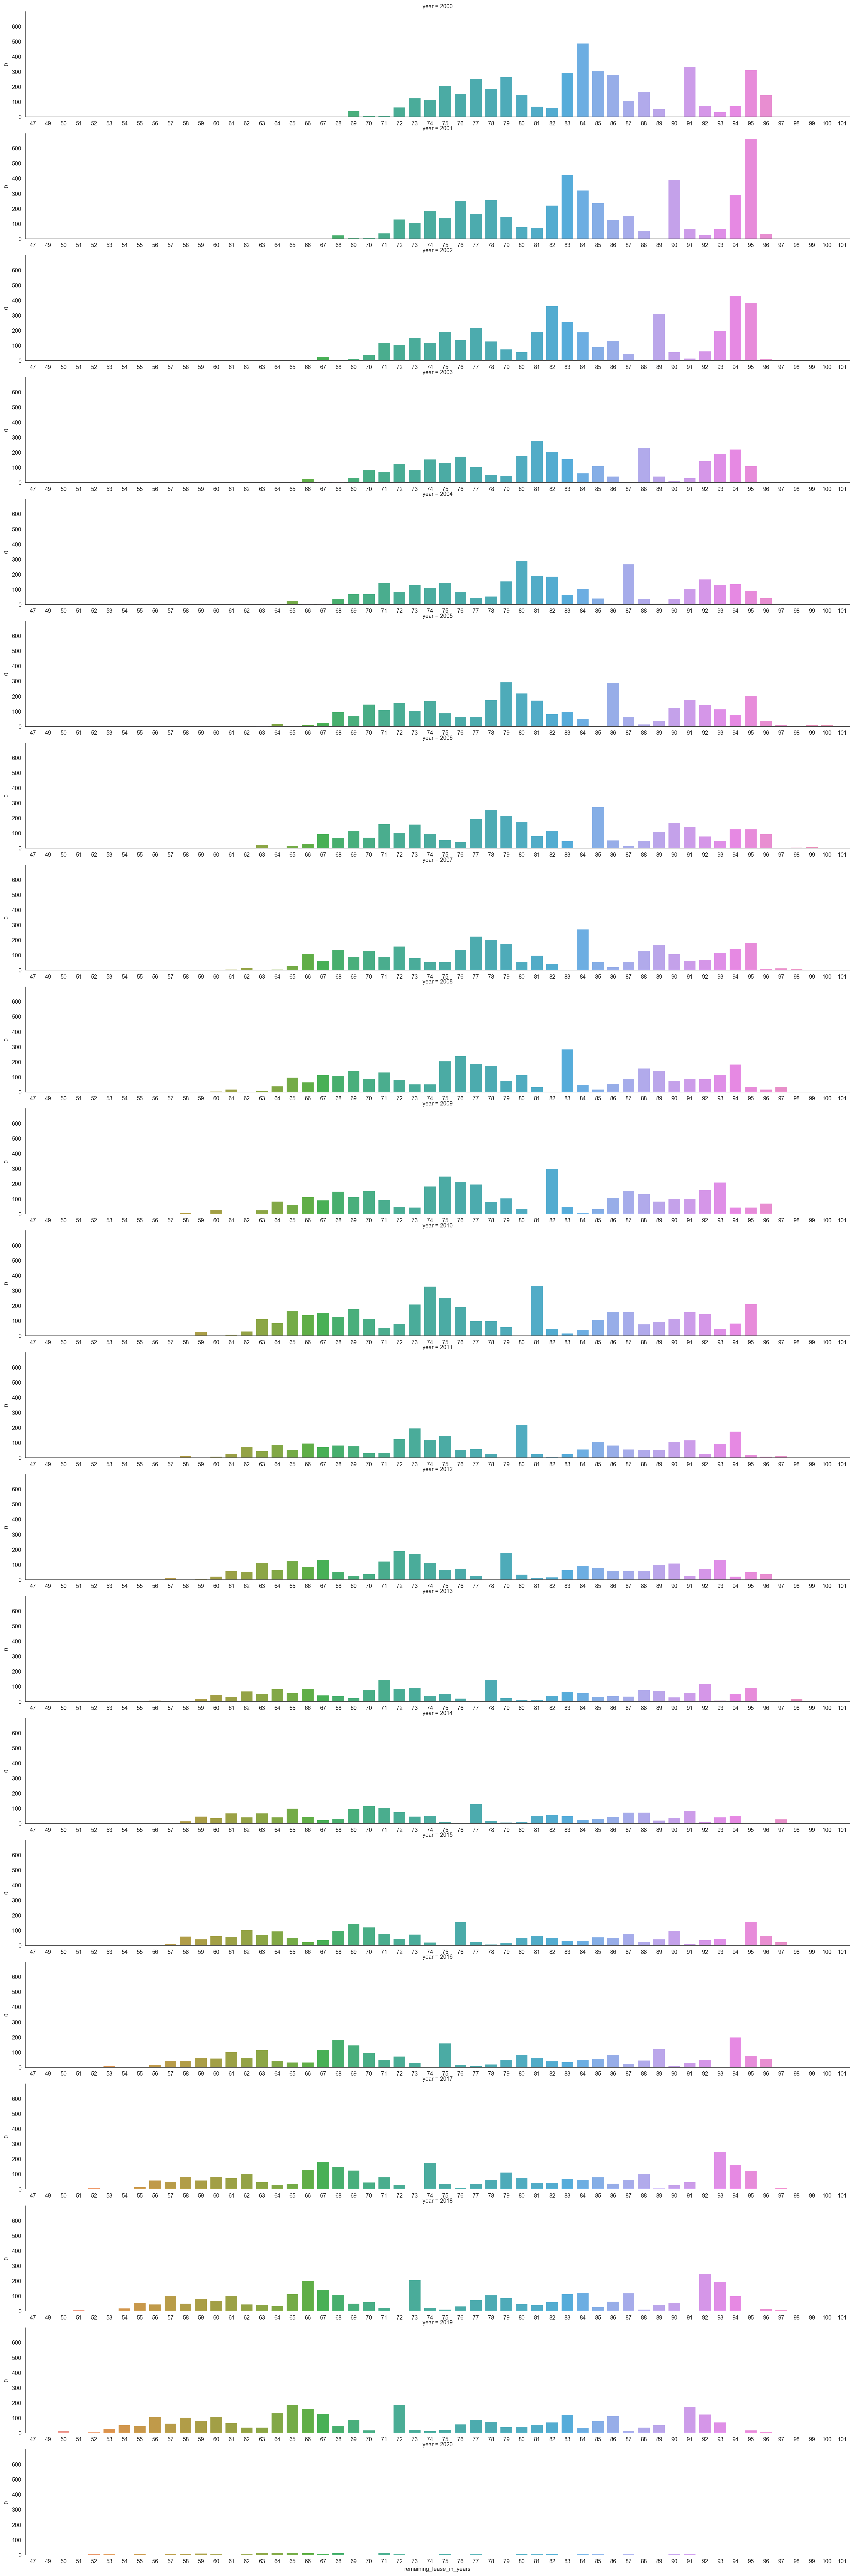

In [141]:
g = sns.catplot(x='remaining_lease_in_years', y=0, col='year', col_wrap=1, data=flats_sold_counts, 
            kind='bar', height=3, aspect=7)

# for ax in g.axes.flatten():
#     ax.tick_params(labelbottom=True)

for ax in g.axes.flat:
    _ = plt.setp(ax.get_xticklabels(), visible=True)

Looks like there are batches of flats!

In Year 2000, the peaks are:
- 84 years remaining lease = built in 1985
- 91 years remaining lease = built in 1992
- 95 years remaining lease = built in 1996

In Year 2001, in addition to the above, a new peak in 
- 95 years remaining lease = built in 1997

In 2010, 
- 74 years remaining lease = built in 1985 (same batch as before)
- 81 years remaining lease = built in 1992
- (new) 95 years remaining lease = built in 2006

In 2015, 
- 95 years remaining lease = built in 2012

In [146]:
danchel = (
    (hdb['town']=='ANG MO KIO') &
    (hdb['flat_type'] == '5 ROOM') &
    (hdb['resale_price'] < 500000) &
    (hdb['year'] == 2019)
)
hdb[danchel]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,floor_area_sqft,price_per_sqft,flat_model,lease_commence_date,remaining_lease_in_years,resale_price,lease_commence_year,year,remaining_lease_in_5Y_buckets
42445,2019-01-01,ANG MO KIO,5 ROOM,553,ANG MO KIO AVE 10,01 TO 03,119.0,1280.9041,366.928328,Improved,1980-01-01,60,470000.0,1980,2019,60
43986,2019-02-01,ANG MO KIO,5 ROOM,622,ANG MO KIO AVE 9,01 TO 03,121.0,1302.4319,368.541342,Improved,1980-01-01,60,480000.0,1980,2019,60
46976,2019-04-01,ANG MO KIO,5 ROOM,642,ANG MO KIO AVE 5,10 TO 12,121.0,1302.4319,360.863397,Improved,1980-01-01,60,470000.0,1980,2019,60
50945,2019-06-01,ANG MO KIO,5 ROOM,460,ANG MO KIO AVE 10,04 TO 06,124.0,1334.7236,359.625019,Improved,1980-01-01,60,480000.0,1980,2019,60
50947,2019-06-01,ANG MO KIO,5 ROOM,401,ANG MO KIO AVE 10,01 TO 03,119.0,1280.9041,343.507371,Improved,1979-01-01,59,440000.0,1979,2019,55
56850,2019-09-01,ANG MO KIO,5 ROOM,460,ANG MO KIO AVE 10,01 TO 03,120.0,1291.6680,364.644785,Improved,1980-01-01,60,471000.0,1980,2019,60
58677,2019-10-01,ANG MO KIO,5 ROOM,102,ANG MO KIO AVE 3,01 TO 03,127.0,1367.0153,364.297313,Improved,1993-01-01,73,498000.0,1993,2019,70
60864,2019-11-01,ANG MO KIO,5 ROOM,501,ANG MO KIO AVE 5,10 TO 12,121.0,1302.4319,364.702369,Improved,1981-01-01,61,475000.0,1981,2019,60
60866,2019-11-01,ANG MO KIO,5 ROOM,648,ANG MO KIO AVE 5,01 TO 03,121.0,1302.4319,376.219286,Improved,1980-01-01,60,490000.0,1980,2019,60
62805,2019-12-01,ANG MO KIO,5 ROOM,439,ANG MO KIO AVE 10,04 TO 06,119.0,1280.9041,380.980902,Improved,1979-01-01,59,488000.0,1979,2019,55


In [147]:
# validate some of these: 
# https://www.straitstimes.com/singapore/housing/to-buy-an-old-hdb-flat-or-not-that-is-the-question

In [ ]:
# what is the oldest priced flat that we can buy
# count of how many flats sold for each remaining lease year (by year sold?)

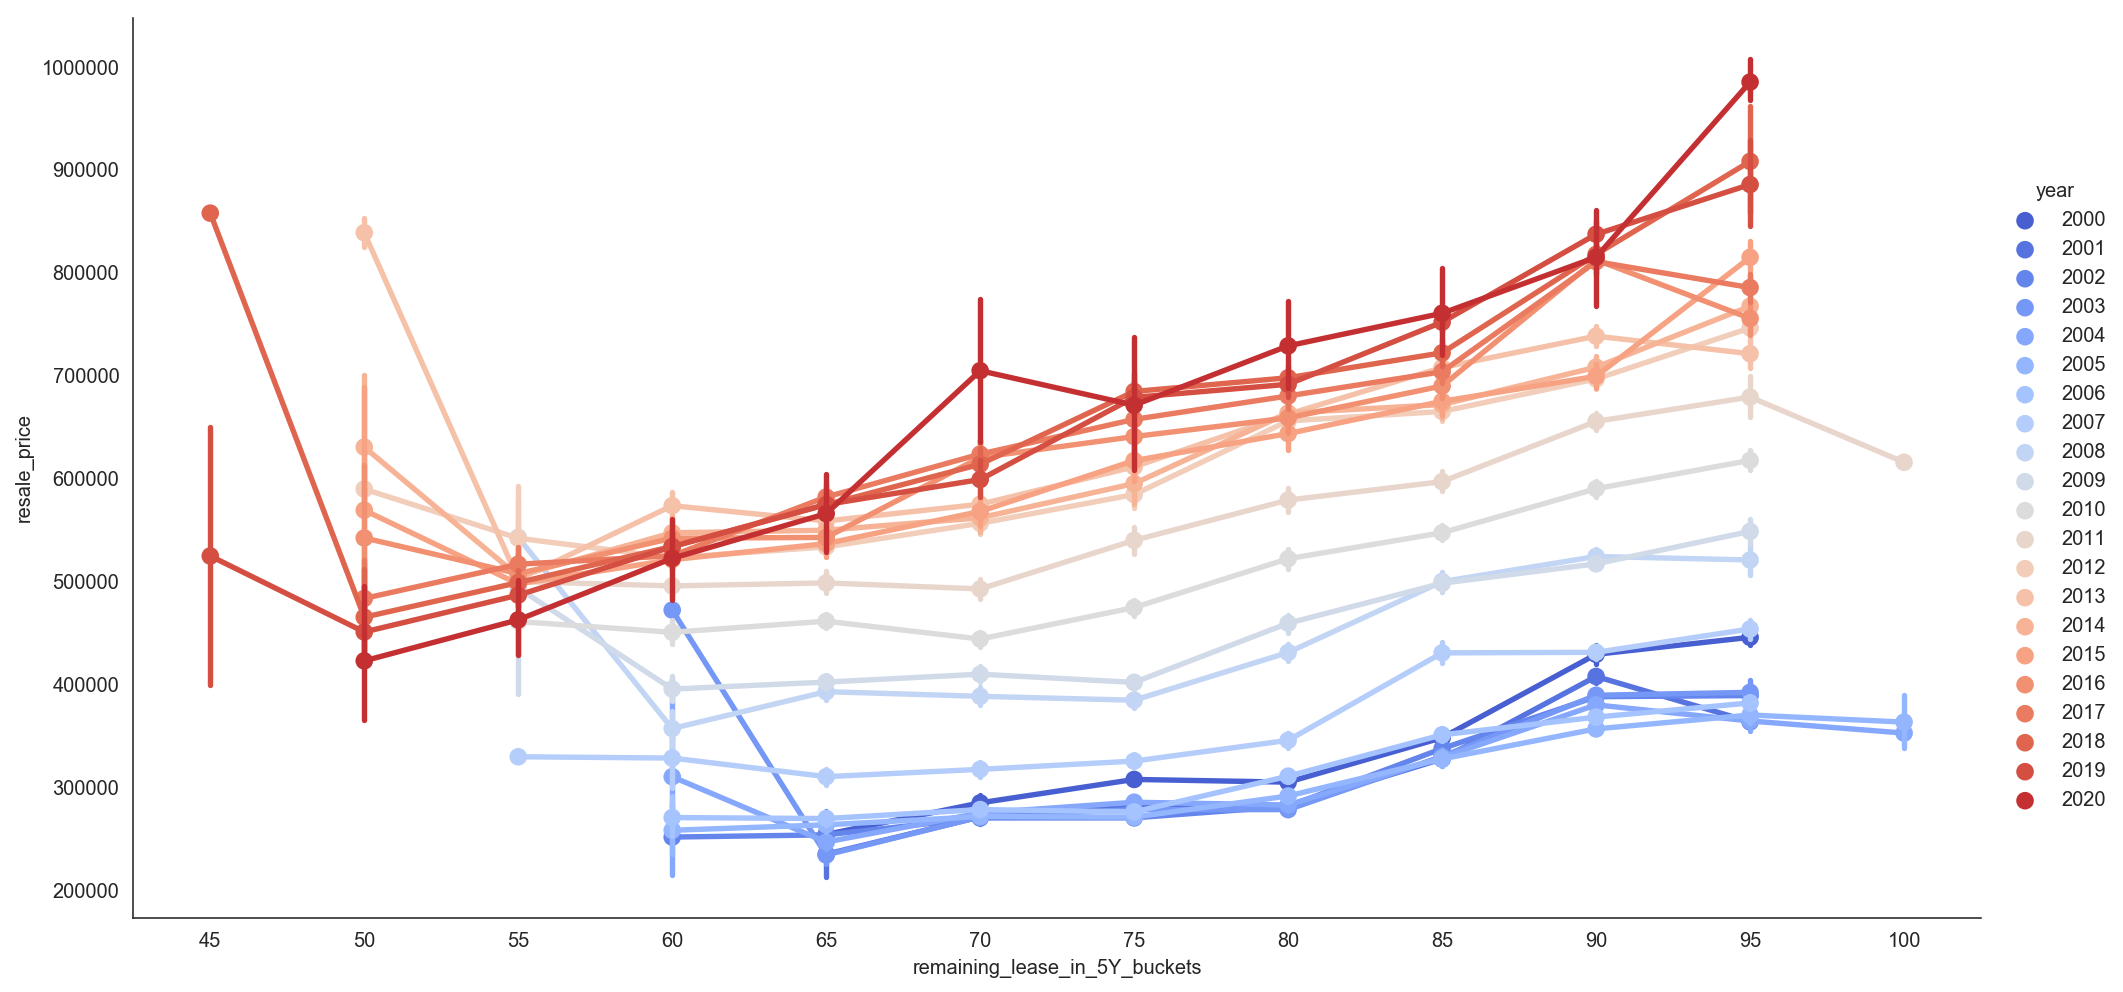

In [98]:
# plot by year sold, resale price, remaining lease as series
hdb_4roomplus_tier1[['year', 'remaining_lease_in_years', 'remaining_lease_in_5Y_buckets', 'resale_price']]

sns.catplot(x='remaining_lease_in_5Y_buckets', y='resale_price', hue='year', 
            data=hdb_4roomplus_tier1, kind='point', height=7, aspect=2, alpha=0.3, palette='coolwarm')

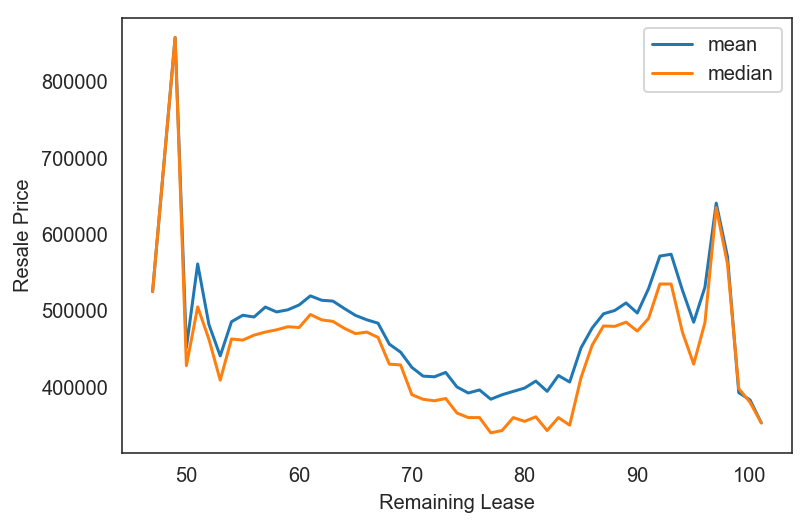

In [67]:
resale_prices_4roomsplus_tier1_by_remaining_lease = (
    hdb_4roomplus_tier1
    .groupby('remaining_lease_in_years')
    .agg(
        {
            'resale_price': [np.mean, np.median, 'count'],
            'price_per_sqft': [np.mean, np.median, 'count']
        }
        )
)

fig, ax = plt.subplots()

x = resale_prices_4roomsplus_tier1_by_year_built.index.to_list()
y = resale_prices_4roomsplus_tier1_by_year_built['resale_price']['mean']
y2 = resale_prices_4roomsplus_tier1_by_year_built['resale_price']['median']

ax.plot(x, y)
ax.plot(x, y2)
ax.set_xlabel('Remaining Lease')
ax.set_ylabel('Resale Price')
plt.legend();

In [68]:
resale_prices_4roomsplus_tier1_by_remaining_lease

resale_price                 price_per_sqft  \
                                   mean    median count           mean   
remaining_lease_in_years                                                 
47                        525000.000000  525000.0     2     439.707556   
49                        858000.000000  858000.0     1     797.108855   
50                        451652.533333  428000.0    15     486.810281   
51                        561277.714286  505000.0    14     531.610825   
52                        481807.692308  462500.0    26     496.160177   
53                        440788.423077  409000.0    52     453.016648   
54                        485576.597701  463000.0    87     477.633231   
55                        494055.985075  461500.0   134     480.546075   
56                        491750.035294  468000.0   255     470.118618   
57                        504794.299035  472000.0   311     476.328951   
58                        498410.700508  475000.0   394     476.256537   
59                        501203.044444  479000.0   450     470.197282   
60                        507548.383057  478000.0   543     480.917662   
61                        519465.369085  495000.0   634     482.735800   
62                        513720.792890  488000.0   647     478.895052   
63                        512597.510856  486000.0   783     469.583678   
64                        502989.412170  477000.0   871     459.352894   
65                        493877.618120  470000.0  1181     449.653049   
66                        488112.377289  472000.0  1365     433.890572   
67                        483650.790301  465000.0  1464     429.900659   
68                        456258.901345  430000.0  1561     409.384546   
69                        445727.929526  429000.0  1646     401.122238   
70                        425742.787239  390000.0  1514     380.733330   
71                        414303.601562  383944.0  1664     368.270350   
72                        413429.972218  382000.0  1948     363.352875   
73                        419171.966427  385000.0  2085     360.279818   
74                        400117.843006  366000.0  2129     346.428238   
75                        392197.558744  360000.0  2230     339.565316   
76                        396196.530024  360000.0  2115     334.987596   
77                        384064.580528  340000.0  2198     326.532579   
78                        389881.653176  343000.0  2125     326.732564   
79                        394311.491803  360000.0  2135     329.187791   
80                        398637.747611  355000.0  1934     333.390212   
81                        407818.373684  361000.0  1900     338.620838   
82                        394359.521932  343000.0  2029     333.505851   
83                        415128.839136  360000.0  2269     358.200497   
84                        406547.488885  350000.0  2125     353.188225   
85                        451146.821134  412000.0  1817     383.169159   
86                        477471.515336  455000.0  1844     409.183110   
87                        495972.451733  480000.0  1633     426.564535   
88                        500310.497969  479500.0  1536     433.354529   
89                        510174.482292  485000.0  1553     449.451442   
90                        496991.053492  473300.0  1678     436.458569   
91                        529049.498375  490000.0  1846     469.791961   
92                        571573.445457  535000.0  1847     513.687319   
93                        574009.315783  535000.0  2115     515.991883   
94                        526955.267885  472000.0  2572     472.480648   
95                        484929.991708  430000.0  2909     441.156462   
96                        530951.974242  484500.0   660     497.007855   
97                        641003.266667  635000.0   165     611.226298   
98                        570745.238095  561500.0    42     539.882149   
99                        39263

In [59]:
hdb_4room_plus

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,floor_area_sqft,price_per_sqft,flat_model,lease_commence_date,remaining_lease_in_years,resale_price,lease_commence_year,year,remaining_lease_in_5Y_buckets
53829,2019-07-01,KALLANG/WHAMPOA,5 ROOM,8,BOON KENG RD,37 TO 39,119.0,1280.9041,940.741778,DBSS,2011-01-01,91,1205000.0,2011,2019,90
47273,2019-04-01,BUKIT MERAH,5 ROOM,9A,BOON TIONG RD,34 TO 36,112.0,1205.5568,995.390678,Improved,2016-01-01,96,1200000.0,2016,2019,95
55313,2019-08-01,CENTRAL AREA,5 ROOM,1C,CANTONMENT RD,40 TO 42,106.0,1140.9734,1051.733546,Type S2,2011-01-01,91,1200000.0,2011,2019,90
51323,2019-06-01,CENTRAL AREA,5 ROOM,1C,CANTONMENT RD,40 TO 42,106.0,1140.9734,1041.216211,Type S2,2011-01-01,91,1188000.0,2011,2019,90
43164,2019-01-01,KALLANG/WHAMPOA,5 ROOM,9,BOON KENG RD,37 TO 39,117.0,1259.3763,940.941957,DBSS,2011-01-01,91,1185000.0,2011,2019,90
1321,2017-02-01,BISHAN,5 ROOM,273B,BISHAN ST 24,40 TO 42,120.0,1291.6680,913.547444,DBSS,2011-01-01,93,1180000.0,2011,2017,90
50101,2019-05-01,QUEENSTOWN,5 ROOM,18C,HOLLAND DR,37 TO 39,117.0,1259.3763,929.031299,Improved,2012-01-01,92,1170000.0,2012,2019,90
37101,2018-10-01,CENTRAL AREA,5 ROOM,1D,CANTONMENT RD,40 TO 42,106.0,1140.9734,1023.687318,Type S2,2011-01-01,92,1168000.0,2011,2018,90
34334,2018-08-01,TOA PAYOH,5 ROOM,139A,LOR 1A TOA PAYOH,40 TO 42,117.0,1259.3763,921.795972,DBSS,2012-01-01,93,1160888.0,2012,2018,90
10770,2017-07-01,QUEENSTOWN,EXECUTIVE,148,MEI LING ST,19 TO 21,156.0,1679.1684,690.818145,Apartment,1995-01-01,77,1160000.0,1995,2017,75


In [40]:
# are there flats that were built in a certain time range that are more popular?
# correlation between year hdb was made vs resale price



In [43]:
hdb_4roomplus_tier1

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,floor_area_sqft,price_per_sqft,flat_model,lease_commence_date,remaining_lease_in_years,resale_price,lease_commence_year,year,remaining_lease_in_5Y_buckets
53829,2019-07-01,KALLANG/WHAMPOA,5 ROOM,8,BOON KENG RD,37 TO 39,119.0,1280.90410,940.741778,DBSS,2011-01-01,91,1205000.0,2011,2019,90
47273,2019-04-01,BUKIT MERAH,5 ROOM,9A,BOON TIONG RD,34 TO 36,112.0,1205.55680,995.390678,Improved,2016-01-01,96,1200000.0,2016,2019,95
55313,2019-08-01,CENTRAL AREA,5 ROOM,1C,CANTONMENT RD,40 TO 42,106.0,1140.97340,1051.733546,Type S2,2011-01-01,91,1200000.0,2011,2019,90
51323,2019-06-01,CENTRAL AREA,5 ROOM,1C,CANTONMENT RD,40 TO 42,106.0,1140.97340,1041.216211,Type S2,2011-01-01,91,1188000.0,2011,2019,90
43164,2019-01-01,KALLANG/WHAMPOA,5 ROOM,9,BOON KENG RD,37 TO 39,117.0,1259.37630,940.941957,DBSS,2011-01-01,91,1185000.0,2011,2019,90
1321,2017-02-01,BISHAN,5 ROOM,273B,BISHAN ST 24,40 TO 42,120.0,1291.66800,913.547444,DBSS,2011-01-01,93,1180000.0,2011,2017,90
50101,2019-05-01,QUEENSTOWN,5 ROOM,18C,HOLLAND DR,37 TO 39,117.0,1259.37630,929.031299,Improved,2012-01-01,92,1170000.0,2012,2019,90
37101,2018-10-01,CENTRAL AREA,5 ROOM,1D,CANTONMENT RD,40 TO 42,106.0,1140.97340,1023.687318,Type S2,2011-01-01,92,1168000.0,2011,2018,90
34334,2018-08-01,TOA PAYOH,5 ROOM,139A,LOR 1A TOA PAYOH,40 TO 42,117.0,1259.37630,921.795972,DBSS,2012-01-01,93,1160888.0,2012,2018,90
10770,2017-07-01,QUEENSTOWN,EXECUTIVE,148,MEI LING ST,19 TO 21,156.0,1679.16840,690.818145,Apartment,1995-01-01,77,1160000.0,1995,2017,75


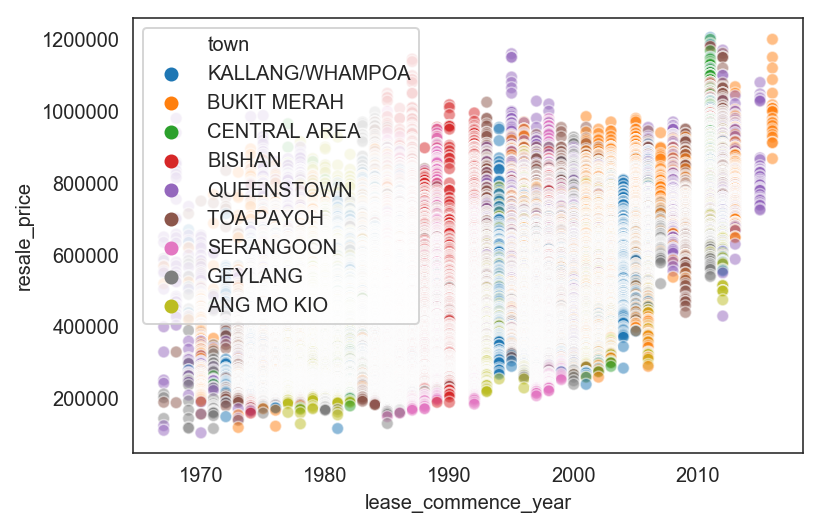

In [46]:
sns.scatterplot(x='lease_commence_year', y='resale_price', data=hdb_4roomplus_tier1, alpha=0.5, hue='town');

In [23]:
hdb[['lease_commence_year', 'resale_price']].corr()

,lease_commence_year,resale_price
lease_commence_year,1.000000,0.422979
resale_price,0.422979,1.000000


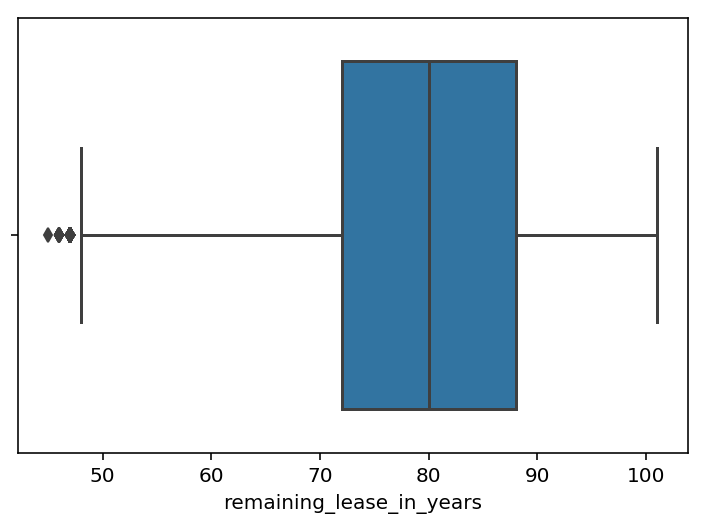

In [107]:
sns.boxplot(hdb['remaining_lease_in_years'])

In [123]:
hdb[(hdb['remaining_lease_in_years']<65) & 
    (hdb['year']==2019) & 
    (hdb['town']=='ANG MO KIO') & 
    (hdb['storey_range']=='04 TO 06') &
    (hdb['flat_type'] == '5 ROOM')]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,floor_area_sqft,flat_model,lease_commence_date,remaining_lease_in_years,resale_price,year
50945,2019-06-01,ANG MO KIO,5 ROOM,460,ANG MO KIO AVE 10,04 TO 06,124.0,1334.7236,Improved,1980-01-01,60,480000.0,2019
50952,2019-06-01,ANG MO KIO,5 ROOM,620,ANG MO KIO AVE 9,04 TO 06,121.0,1302.4319,Improved,1980-01-01,60,568000.0,2019
52835,2019-07-01,ANG MO KIO,5 ROOM,305,ANG MO KIO AVE 1,04 TO 06,123.0,1323.9597,Standard,1977-01-01,57,525000.0,2019
54960,2019-08-01,ANG MO KIO,5 ROOM,501,ANG MO KIO AVE 5,04 TO 06,121.0,1302.4319,Improved,1981-01-01,61,515000.0,2019
56849,2019-09-01,ANG MO KIO,5 ROOM,437,ANG MO KIO AVE 10,04 TO 06,119.0,1280.9041,Improved,1979-01-01,59,508000.0,2019
56852,2019-09-01,ANG MO KIO,5 ROOM,101,ANG MO KIO AVE 3,04 TO 06,117.0,1259.3763,Standard,1978-01-01,58,506888.0,2019
58678,2019-10-01,ANG MO KIO,5 ROOM,111,ANG MO KIO AVE 4,04 TO 06,117.0,1259.3763,Improved,1978-01-01,58,518000.0,2019
58683,2019-10-01,ANG MO KIO,5 ROOM,710,ANG MO KIO AVE 8,04 TO 06,117.0,1259.3763,Improved,1980-01-01,60,555000.0,2019
60865,2019-11-01,ANG MO KIO,5 ROOM,521,ANG MO KIO AVE 5,04 TO 06,118.0,1270.1402,Improved,1980-01-01,60,508000.0,2019
62805,2019-12-01,ANG MO KIO,5 ROOM,439,ANG MO KIO AVE 10,04 TO 06,119.0,1280.9041,Improved,1979-01-01,59,488000.0,2019


(array([  1005.,   6358.,  18335.,  48344.,  63855.,  96103., 103721.,
         69412., 112267.,   6104.]),
 array([ 45. ,  50.6,  56.2,  61.8,  67.4,  73. ,  78.6,  84.2,  89.8,
         95.4, 101. ]),
 <a list of 10 Patch objects>)

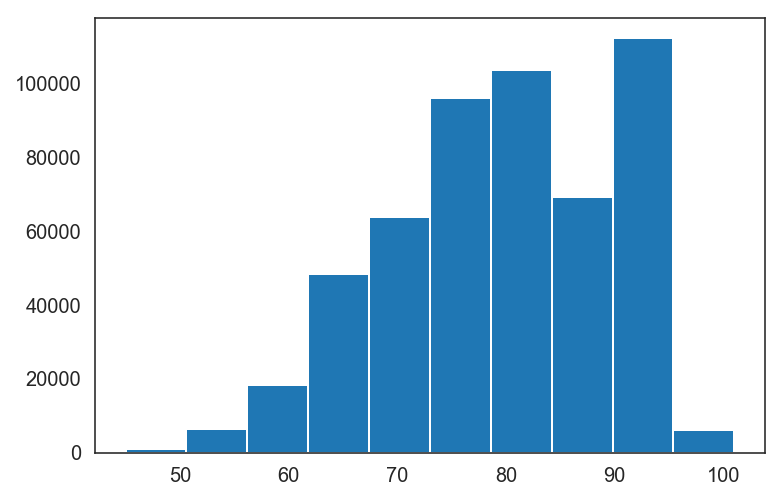

In [110]:
plt.hist(hdb['remaining_lease_in_years'])

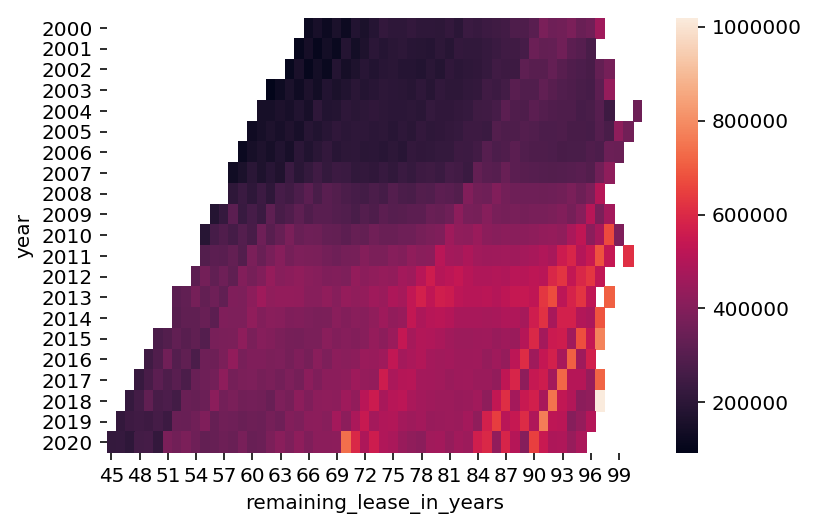

In [105]:
sns.heatmap(hdb.groupby(['year', 'remaining_lease_in_years'])['resale_price'].mean().unstack())

In [92]:
hdb[['month', 'remaining_lease_in_years', 'resale_price']]

,month,remaining_lease_in_years,resale_price
0,2000-01-01,85,147000.0
1,2000-01-01,85,144000.0
2,2000-01-01,75,159000.0
3,2000-01-01,75,167000.0
4,2000-01-01,75,163000.0
5,2000-01-01,76,157000.0
6,2000-01-01,76,178000.0
7,2000-01-01,80,160000.0
8,2000-01-01,80,169000.0
9,2000-01-01,80,205000.0
